In [1]:
import pandas as pd
import cluj_tools as ct

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

from secrets import *

### Get Rosters

In [2]:
matchup_end_date, matchupPeriod = ct.matchup_end_date()

Matchup end date is 2020-02-23
Matchup period is 17


In [3]:
rosters = ct.get_rosters(matchupPeriod)

### Get Boxscore data to calculate octys

In [4]:
dbname = 'cluj'
engine = create_engine('postgres://%s:%s@localhost/%s'%(AUTH['db_user'],AUTH['db_pass'],dbname))

if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [5]:
sql = """
    SELECT * FROM boxscores b
    LEFT JOIN player_name_comparison c ON b.name = c.boxscore_name
    WHERE b.season_year = '2019-2020' AND b.season_type = 'regular'
"""

In [6]:
boxscores = pd.read_sql(sql, engine)
boxscores['ft_pct'] = boxscores.ftm / boxscores.fta
boxscores['fg_pct'] = boxscores.fgm / boxscores.fga

In [7]:
boxscores.loc[boxscores.espn_name.isnull(),'espn_name'] = boxscores.loc[boxscores.espn_name.isnull(),'name']

In [8]:
ft_pct_threshold = 0.75
fg_pct_threshold = 0.4
octys = boxscores.loc[(boxscores.assists > 0) & (boxscores.threes > 0) & (boxscores.steals > 0) & (boxscores.rebounds > 0) & (boxscores['blocks'] > 0) & (boxscores.ft_pct > ft_pct_threshold) & (boxscores.fg_pct > fg_pct_threshold)]
octys.shape

(426, 21)

In [9]:
octy_counts = pd.DataFrame(octys.espn_name.value_counts())
octy_counts.reset_index(inplace=True)
octy_counts.rename(columns={'espn_name':'octy_count', 'index':'espn_name'}, inplace=True)

In [10]:
octy_counts.head()

,espn_name,octy_count
0,Anthony Davis,14
1,James Harden,12
2,Kawhi Leonard,10
3,Joel Embiid,9
4,Brandon Ingram,8


In [11]:
octys_games = pd.DataFrame(boxscores.groupby('espn_name')['assists'].count())
octys_games.reset_index(inplace=True)
octys_games.rename(columns={'assists':'game_count'}, inplace=True)

In [12]:
merged = octy_counts.merge(octys_games, on='espn_name')
merged['octy_pct'] = merged.octy_count / merged.game_count
merged.sort_values('octy_pct', ascending=False, inplace=True)
merged.shape

(179, 4)

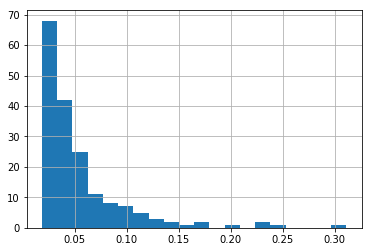

In [13]:
merged.octy_pct.hist(bins=20)

In [14]:
merged.head(30)

,espn_name,octy_count,game_count,octy_pct
0,Anthony Davis,14,45,0.311111
2,Kawhi Leonard,10,41,0.243902
1,James Harden,12,51,0.235294
3,Joel Embiid,9,39,0.230769
25,Kyrie Irving,4,20,0.200000
17,John Collins,5,29,0.172414
4,Brandon Ingram,8,47,0.170213
8,Pascal Siakam,7,43,0.162791
10,Josh Richardson,6,41,0.146341
6,Jayson Tatum,7,49,0.142857


In [15]:
rosters_merge = merged.merge(rosters, left_on='espn_name', right_on='fullName', how='left')
rosters_merge.shape

(179, 6)

In [16]:
rosters_merge.groupby('teamId')['octy_pct'].mean().sort_values()

teamId
1.0     0.049598
2.0     0.052752
12.0    0.054552
11.0    0.054746
9.0     0.054900
6.0     0.060366
3.0     0.063751
8.0     0.069401
10.0    0.070199
5.0     0.077396
7.0     0.078977
4.0     0.095520
Name: octy_pct, dtype: float64

In [18]:
rosters_merge.groupby('teamId')['octy_count'].sum().sort_values()

teamId
2.0     18
1.0     21
12.0    22
8.0     24
9.0     24
11.0    24
6.0     25
3.0     27
7.0     32
5.0     35
10.0    37
4.0     50
Name: octy_count, dtype: int64

In [19]:
rosters_merge.loc[rosters_merge.teamId == 10]

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
8,Josh Richardson,6,41,0.146341,Josh Richardson,10.0
12,Nikola Jokic,7,54,0.129630,Nikola Jokic,10.0
16,Myles Turner,5,44,0.113636,Myles Turner,10.0
24,Mikal Bridges,5,54,0.092593,Mikal Bridges,10.0
33,Miles Bridges,4,53,0.075472,Miles Bridges,10.0
74,Derrick Rose,2,44,0.045455,Derrick Rose,10.0
84,Jeff Teague,2,47,0.042553,Jeff Teague,10.0
87,Giannis Antetokounmpo,2,48,0.041667,Giannis Antetokounmpo,10.0
105,Justin Holiday,2,54,0.037037,Justin Holiday,10.0
117,Elfrid Payton,1,35,0.028571,Elfrid Payton,10.0


In [20]:
# should only be players on waiver wire
rosters_merge.loc[rosters_merge.fullName.isnull()].sort_values('octy_pct', ascending=False).head(20)

,espn_name,octy_count,game_count,octy_pct,fullName,teamId
19,Kadeem Allen,1,10,0.100000,NaN,NaN
23,Jonathan Isaac,3,32,0.093750,NaN,NaN
28,Justise Winslow,1,11,0.090909,NaN,NaN
35,PJ Dozier,1,14,0.071429,NaN,NaN
43,Jabari Parker,2,32,0.062500,NaN,NaN
46,Josh Okogie,3,50,0.060000,NaN,NaN
50,Derrick White,3,52,0.057692,NaN,NaN
54,Maxi Kleber,3,53,0.056604,NaN,NaN
55,OG Anunoby,3,53,0.056604,NaN,NaN
62,Damion Lee,2,38,0.052632,NaN,NaN
